In [1]:
from FisherLD import FisherLD
import numpy as np

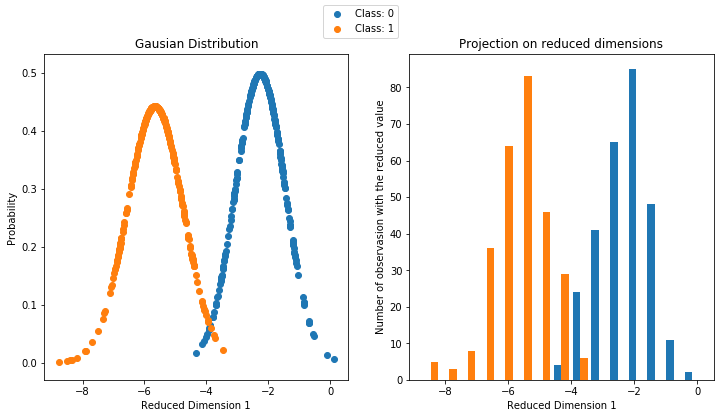

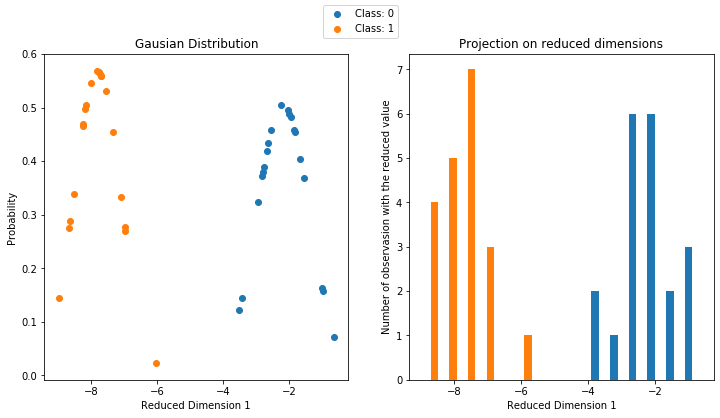

In [2]:
Data=np.loadtxt('Data1.txt')
X = Data[:,0:2]
t = Data[:,2]
classifier = FisherLD(X,t)
TestData = np.loadtxt('Test1.txt')
X_test = np.matrix(TestData)
t_test = classifier.classify(TestData)
f = classifier.project_on_reduced_dimensions(X_test, t_test)

In [3]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
iris = load_iris()
features = iris.data.T
X = np.vstack((features[0], features[1]))
t = iris.target
classifier = FisherLD(X,t)
f, t = classifier.project_and_classify(X)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 150

In [4]:
X = df[["sepal length in cm", "sepal width in cm", "petal length in cm", "petal width in cm"]]
t = df["class label"]

from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
label_encoder = enc.fit(t)
t = label_encoder.transform(t) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

NameError: name 'df' is not defined

In [5]:
classifier = FisherLD(X,t)
f, t = classifier.project_and_classify(X)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 150

[array([], dtype=float64), array([-0.00559396, -0.00540147, -0.005639  , -0.00424635, -0.00548183,
       -0.00513772, -0.00747526, -0.00553613, -0.00544193, -0.00454312,
       -0.00388448, -0.00525123, -0.00552004, -0.00546775, -0.00570525,
       -0.0057423 , -0.00584628, -0.00618656, -0.00506747, -0.00550905,
       -0.00716612, -0.00639264, -0.0047666 , -0.00473328, -0.00493731,
       -0.00498385, -0.00581478, -0.00495658, -0.00546995, -0.00641458,
       -0.00450978, -0.00635924, -0.00596744, -0.00609705, -0.00732372,
       -0.00566553, -0.00645121, -0.00563616, -0.00644912, -0.00805272,
       -0.00507626, -0.00615058, -0.00642574, -0.00525233, -0.00614988,
       -0.0041387 , -0.00604703, -0.00576733, -0.00523014, -0.00383836,
       -0.00524411, -0.00576675, -0.00605559, -0.00474751, -0.00506277,
       -0.0059678 , -0.00572608, -0.00675179,  0.00440621, -0.00530459,
       -0.00543107, -0.00394399, -0.00572581, -0.00545579, -0.0055233 ,
       -0.00502623, -0.00535858, -0.0

/home/mostafakm/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mostafakm/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mostafakm/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/mostafakm/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/mostafakm/Documents/NU ML/Fisher's Linear Discriminant/FisherLD.py:117: RuntimeWarning: Degrees of freedom <= 0 for slice
  mvn_now = multivariate_normal(np.mean(y[i]),np.cov(y[i]))
/home/mostafakm/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
 

ValueError: array must not contain infs or NaNs

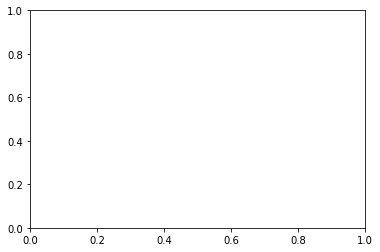

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end



X = df[["sepal length in cm", "sepal width in cm", "petal length in cm", "petal width in cm"]]
t = df["class label"]




enc = LabelEncoder()
label_encoder = enc.fit(t)
t = label_encoder.transform(t) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}
train_data, test_data, train_lbl, test_lbl = train_test_split(X, t, test_size = 0.2, random_state = 100)
classifier = FisherLD(X,t)

t = classifier.classify(X)

f = classifier.project_on_reduced_dimensions(X,t)